In [146]:
import numpy as np
from math import floor
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
from imageio import imread
import matplotlib.cbook as cbook
from skimage import measure

import time

% matplotlib inline

In [3]:
query=' '.join([
                'SELECT *',
               'FROM gaiadr2.gaia_source',
               'WHERE 1=CONTAINS(POINT(\'ICRS\', ra, dec),BOX(\'ICRS\', 149, 10, 16,16))'
                ])
               
               
llcc=Gaia.launch_job_async(query).get_results()

Launched query: 'SELECT * FROM gaiadr2.gaia_source WHERE 1=CONTAINS(POINT('ICRS', ra, dec),BOX('ICRS', 149, 10, 16,16))'
Retrieving async. results...


Query finished.


In [8]:
mag_thres=10
bright=llcc[llcc['phot_g_mean_mag']<mag_thres]
bright.sort('parallax')
bright.reverse()
bright=bright[np.where(bright['parallax']!=np.ma.core.MaskedConstant)]

(8, 16)

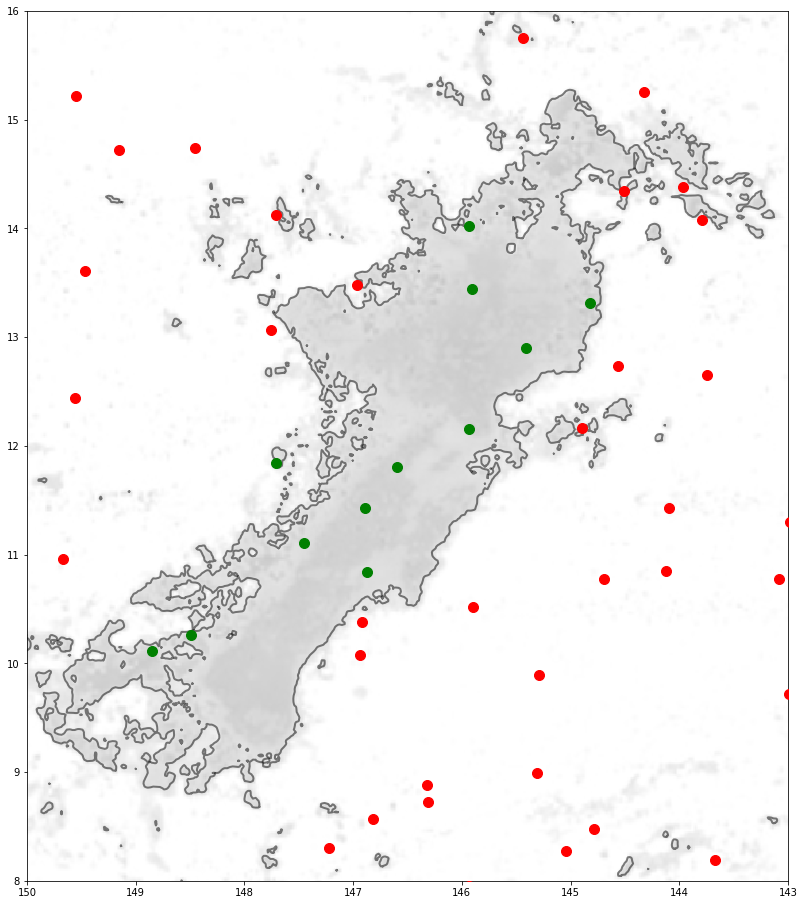

In [132]:
# 0-255 scale, higher == more lenient, lower == more conservative
contour_thres=200

fig=plt.figure(1,figsize=(16,16))
subplt=plt.subplot(111)
#plt.scatter(llcc['ra'],llcc['dec'],marker='o',color='k',s=0.1)

datafile = cbook.get_sample_data('/Users/codydirks/Desktop/llcc.png')
img = 255-np.dot(imread(datafile)[...,:3], [0.299, 0.587, 0.114])
plt.imshow(img, zorder=-1, extent=[157, 141, 2, 18],alpha=0.5,cmap=plt.get_cmap('gray'))

# Find and plot contours given above threshold parameter
contours = measure.find_contours(img, contour_thres)
for n, contour in enumerate(contours):
    subplt.plot(contour[:, 1]*(-16./1290.)+157, contour[:, 0]*(-16./1286)+18, linewidth=2,color='k',alpha=0.5)

in_llcc_footprint=[]
for br in bright:
    x=int(round((br['ra']-157)*(-1290./16.),0))
    y=int(round((br['dec']-18)*(-1286./16.),0))
    col='r'
    if img[y][x]<contour_thres and 143<br['ra']<150 and 8<br['dec']<16:
        in_llcc_footprint.append(br.index)
        col='g'
    subplt.plot(br['ra'],br['dec'],marker='o',color=col,markersize=10,zorder=3)
        #subplt.text(br['ra']-0.05,br['dec']+0.15,br['source_id'],rotation=10,backgroundcolor='0.75',zorder=2)

subplt.set_xlim(150,143)
subplt.set_ylim(8,16)

In [152]:
contour_thres=220
i=0
start=time.time()
for l in llcc:
    x=int(floor((l['ra']-157)*(-80.625)))
    y=int(floor((l['dec']-18)*(-80.375)))
    if img[y][x]<contour_thres:
        i=i+1
print i, round(time.time()-start,2)

105451 304.67
